# Handling Overfitting

In [1]:
# Handling overfitting in deep learning models
# SOURCE: Towards Data Science
# https://towardsdatascience.com/handling-overfitting-in-deep-learning-models-c760ee047c6e

# import sys
# !conda install --yes --prefix {sys.prefix} keras

In [2]:
# deep learning models with overfitting
import pandas as pd
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\myjar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# packages for modelling
from keras import models
from keras import layers
from keras import regularizers

# packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


In [5]:
# Parameter indicating the number of words for the dictionary
NB_WORDS = 100

# Number of Epochs we usually start to train with
NB_START_EPOCHS = 20

# Size of batches used in the mini-batch gradient descent
BATCH_SIZE = 512

# maximum number of words in a sequence
MAX_LEN = 20

root = Path('../')
input_path = root / 'input/'
output_path = root / 'output/'
source_path = root / 'source/'

# Helper functions

In [6]:
def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Function to train a multi-class mode.  The number of epochs and 
    batch_size are set by the constants at the top of the notebook.
    
    Parameters:
        model : model with the chosen architecutre
        X_train : training features
        y_train : training target
        X_valid : validation features
        y_valid : validation target
    Output:
        model training history
    '''
    model.compile(optimizer='rmsprop',
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy']
                 )
    history = model.fit(X_train,
                       y_train,
                       epochs = NB_START_EPOCHS,
                       batch_size = BATCH_SIZE,
                       validation_data = (X_valid, y_valid),
                       verbose = 0
                       )
    return history

def eval_metric(model, history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric.
    Training and validation metric are plotted in a 
    line chart for each epoch
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
        
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]
    
    e = range(1, NB_START_EPOCHS + 1)
    
    plt.plot(e, metric, 'bo', label = 'Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label = 'Validation ' + metric_name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation ' + metric_name + \
              ' for ' + model.name)
    plt.legend()
    plt.show()
    
def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train,
             y_train,
             epochs = epoch_stop,
             batch_size = BATCH_SIZE,
             verbose = 0
             )
    
    results = model.evaluate(X_test, y_test)
    print()
    print('Test accuracy: {0:.2f}%'.format(results[1]*100))
    return results

def remove_stopwords(input_text):
    '''
    Function to remove English stopwords from a Pandas series.
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series
    '''
    stopwords_list = stopwords.words('english')
    # some words which might indicate a certain sentiment are kept
    #   via a white list
    whitelist =["n't", "not", "no"]
    words = input_text.split()
    clean_words = [
        word for word in words if (
            word not in stopwords_list or word in whitelist
        ) and len(word) > 1
    ]
    return " ".join(clean_words)

def remove_mentions(input_text):
    '''
    Function to remove mentions, preceted by @, in a Pandas series.
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series
    '''
    return re.sub(r'@\w+', '', input_text)

def compare_models_by_metric(
    model_1, 
    model_2, 
    model_hist_1,
    model_hist_2,
    metric
):
    '''
    Function to compare a metric between two models
    
    Parameters:
        model_hist_1 : training history of model 1
        model_hist_2 : training history of model 2
        metric : metric to compare, loss, acc, val_loss or val_acc
        
    Output:
        plot of metrics of both models
    '''
    metric_model_1 = model_hist_1.history[metric]
    metric_model_2 = model_hist_2.history[metric]
    
    e = range(1, NB_START_EPOCHS +1)
    
    metrics_dict = {
        'acc' : 'Training Accuracy',
        'loss' : 'Training Loss',
        'val_acc' : 'Validation accuracy',
        'val_loss' : 'Validation loss'
    }
    
    metric_label = metrics_dict[metric]
    
    plt.plot(e, metric_model_1, 'bo', label = model_1.name)
    plt.plot(e, metric_model_2, 'b', label = model_2.name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_label)
    plt.title('Comparing ' + metric_label + ' between models')
    plt.legend()
    plt.show()
    
def optimal_epoch(model_hist):
    '''
    Function to return the epoch number where the validation loss is
    at its minimum
    
    Parameters:
        model_hist : training history of model
        
    Output:
        epoch number with minimum validation loss
    '''
    min_epoch = np.argmin(model_hist.history['val_loss']) + 1
    print(
        "Minimum validation loss reached in epoch \
        {}".format(min_epoch)
    )
    return min_epoch

# Data Preparation

In [7]:
#### Load CSV with tweets, perform a random shuffle
#  *** good practice to shuffle data before splitting between a train
#  and test set.

# initially keep only *text* column as input and *airline_sentiment*
#   column as the target

# Then remove *stopwords* as they don't have any value in predicting
#   sentiment.  Further clean the data by removing mentions

In [8]:
df = pd.read_csv(input_path / 'Tweets.csv', encoding = "ISO-8859-1")
df = df.reindex(np.random.permutation(df.index))
df = df[['text', 'airline_sentiment']]
df.text = df.text.apply(remove_stopwords).apply(remove_mentions)

# Train-test split

In [9]:
# evaluate the model on a separate test set
X_train, X_test, y_train, y_test = train_test_split(
    df.text,
    df.airline_sentiment,
    test_size = 0.1,
    random_state = 37
)

# Converting words to numbers

In [10]:
# need to first convert the words into tokens
#  a TOKEN is simply converting words to integers that refer to an 
#  index in a dictionary.

# simplify by keeping only the most frequent words in the training set

# clearn up by applying *filters* and putting the words to *lowercase*
#  Words are separated by spaces

In [11]:
tk = Tokenizer(
    num_words = NB_WORDS,
    filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{"}~\t\n',
    lower = True,
    char_level = False,
    split = ' '
)
tk.fit_on_texts(X_train)

In [12]:
# after creating dictionary tk, we can convert the text of a tweet
#  to a vector with NB_WORDS values.

# with *mode=binary*, it contains an indicator whether the word 
#   appeared in the tweet or not.  This is done with the 
#   *texts_to_matrix* method of the Tokenizer

In [13]:
X_train_oh = tk.texts_to_matrix(X_train, mode = 'binary')
X_test_oh = tk.texts_to_matrix(X_test, mode = 'binary')

# Converting the target classes to numbers

In [14]:
# need to convert the target classes to numbers as well
#  Encode using the *to_categorical* method in Keras

In [15]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.fit_transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

# Splitting off a validation set

In [16]:
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(
        X_train_oh,
        y_train_oh,
        test_size = 0.1,
        random_state = 37
    )

# Deep learning

In [17]:
# start with OVERFITTING MODEL
#  2 densely connected layers of 64 elements
#  input_shape for the 1st layer is equal to number of words in the
#  dictionary

# First layer : (10000 x 64) + 64 = 640064
# Second layer : (64 x 64) + 64 = 4160
# Last layer : (64 x 3) + 3 = 195

In [18]:
base_model = models.Sequential()
base_model.add(layers.Dense(
    64,
    activation = 'relu',
    input_shape = (NB_WORDS,)
))
base_model.add(layers.Dense(
    64,
    activation = 'relu'
))
base_model.add(layers.Dense(
    3,
    activation = 'softmax'
))
base_model.name = 'Baseline model'

Minimum validation loss reached in epoch         13


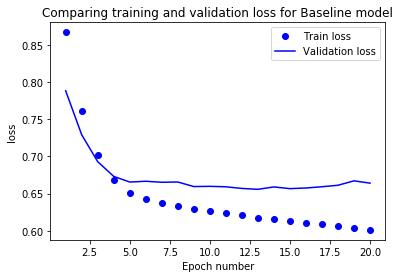

In [19]:
'''Because this project is a multi-class, single-label prediction, we use
categorical_crossentropy as the loss function and softmax as the final
activation function. We fit the model on the train data and validate on the validation
set. We run for a predetermined number of epochs and will see when the model starts
to overfit.
'''
base_history = deep_model(
    base_model,
    X_train_rest,
    y_train_rest,
    X_valid,
    y_valid
)
base_min = optimal_epoch(base_history)
eval_metric(base_model, base_history, 'loss')

# Handling OVERFITTING

In [20]:
'''
3 options to reduce overfitting
1. Reduce network's capacity by removing layers or reducing the number 
of elements in the hidden layers
2. Apply regularization, which comes down to adding a cost to the loss 
function for large weights
3. Use dropout layers, which will randomly remove certain features by
setting them to zero
'''

"\n3 options to reduce overfitting\n1. Reduce network's capacity by removing layers or reducing the number \nof elements in the hidden layers\n2. Apply regularization, which comes down to adding a cost to the loss \nfunction for large weights\n3. Use dropout layers, which will randomly remove certain features by\nsetting them to zero\n"

## Reduce network's capacity

Minimum validation loss reached in epoch         20


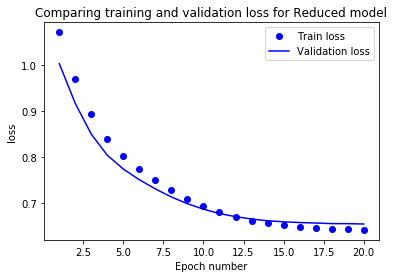

In [21]:
'''
Reducing the network capacity TOO MUCH will result in UNDERFITTING.
The model will not be able to learn the relevant patters in the train
data.
Reduce the capacity by removing one hidden layer and lowering the
number of elements in the remaining layer to 16
'''
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(
    16,
    activation = 'relu', # 1 of 1 layers
    input_shape = (NB_WORDS,)
))
reduced_model.add(layers.Dense(
    3,
    activation = 'softmax' # brings last output later to percentage
))
reduced_model.name = 'Reduced model'

reduced_history = deep_model(
    reduced_model,
    X_train_rest,
    y_train_rest,
    X_valid,
    y_valid
)
reduced_min = optimal_epoch(reduced_history)
eval_metric(reduced_model, reduced_history, 'loss')

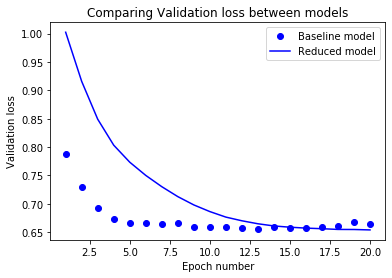

In [22]:
# Compre models
compare_models_by_metric(
    base_model, 
    reduced_model,
    base_history,
    reduced_history,
    'val_loss'
)

In [23]:
# validation loss stays lower much longer than baseline model

## Applying regularization

In [24]:
'''
To address overfitting, we can apply weight regularization to the 
model.  This will add a cost to the loss function of the network
for large weights (or parameter values).  As a result you get a 
simpler model taht will be forced to learn only the relevant 
patterns in the train data.

There are L1 regularization and L2 regularization
* L1 regularization will add a cost with regards to the absolute value 
  of the parameters. It will result in some of the weights to be equal 
  to zero.
  
* L2 regularization will add a cost with regards to the squared value of 
  the parameters. This results in smaller weights.

'''

'\nTo address overfitting, we can apply weight regularization to the \nmodel.  This will add a cost to the loss function of the network\nfor large weights (or parameter values).  As a result you get a \nsimpler model taht will be forced to learn only the relevant \npatterns in the train data.\n\nThere are L1 regularization and L2 regularization\n* L1 regularization will add a cost with regards to the absolute value \n  of the parameters. It will result in some of the weights to be equal \n  to zero.\n  \n* L2 regularization will add a cost with regards to the squared value of \n  the parameters. This results in smaller weights.\n\n'

Minimum validation loss reached in epoch         19


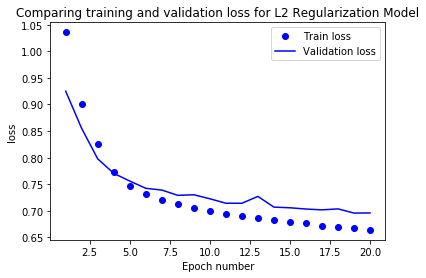

In [25]:
# start with L2 regularization
reg_model = models.Sequential()
reg_model.add(layers.Dense(
    64,
    kernel_regularizer = regularizers.l2(0.001),
    activation = 'relu',
    input_shape = (NB_WORDS,)
))
reg_model.add(layers.Dense(
    64,
    kernel_regularizer = regularizers.l2(0.001),
    activation = 'relu'
))
reg_model.add(layers.Dense(
    3,
    activation = 'softmax'
))
reg_model.name = 'L2 Regularization Model'

reg_history = deep_model(
    reg_model,
    X_train_rest,
    y_train_rest,
    X_valid,
    y_valid
)
reg_min = optimal_epoch(reg_history)
eval_metric(reg_model, reg_history, 'loss')

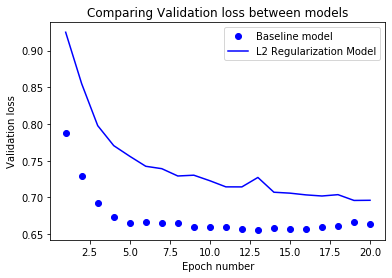

In [26]:
compare_models_by_metric(
    base_model, 
    reg_model,
    base_history,
    reg_history,
    'val_loss'
)

## Adding dropout layers

Minimum validation loss reached in epoch         20


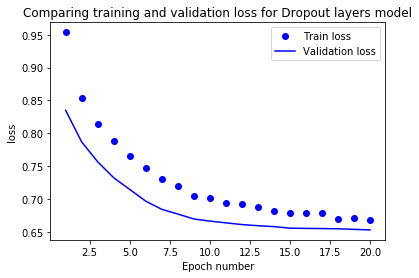

In [27]:
# add dropout layers - which randomly set output features
#  of a layer to zero
drop_model = models.Sequential()
drop_model.add(layers.Dense(
    64,
    activation = 'relu',
    input_shape = (NB_WORDS,)
))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(
    64,
    activation = 'relu'
))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(
    3,
    activation = 'softmax'
))
drop_model.name = 'Dropout layers model'

drop_history = deep_model(
    drop_model,
    X_train_rest,
    y_train_rest,
    X_valid,
    y_valid
)
drop_min = optimal_epoch(drop_history)

eval_metric(drop_model, drop_history, 'loss')

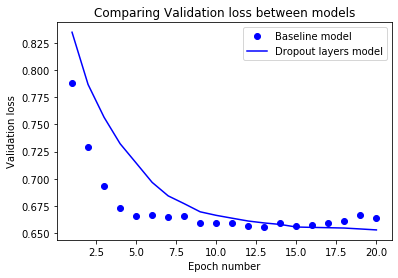

In [28]:
# model with dropout layers starts overfitting later than the 
#  baseline model.  THe loss also increases slower than 
#  baseline model.
compare_models_by_metric(
    base_model,
    drop_model,
    base_history,
    drop_history,
    'val_loss'
)

In [29]:
# the model with the Dropout layers starts overfitting later.
#  compared with the baseline model, the loss also remains lower.

# Training on the full train data and evaluation on test data

In [30]:
# The Reduced model seems to be the best.  Confirm with test set.
base_results = test_model(
    base_model,
    X_train_oh,
    y_train_oh,
    X_test_oh,
    y_test_oh,
    base_min
)
reduced_results = test_model(
    reduced_model,
    X_train_oh,
    y_train_oh,
    X_test_oh,
    y_test_oh,
    reduced_min
)
reg_results = test_model(
    reg_model,
    X_train_oh,
    y_train_oh,
    X_test_oh,
    y_test_oh,
    reg_min
)
drop_results = test_model(
    drop_model,
    X_train_oh,
    y_train_oh,
    X_test_oh,
    y_test_oh,
    drop_min
)

1464/1464 [==============================] - 0s 18us/step

Test accuracy: 71.79%
1464/1464 [==============================] - 0s 18us/step

Test accuracy: 71.11%
1464/1464 [==============================] - 0s 18us/step

Test accuracy: 71.58%
1464/1464 [==============================] - 0s 19us/step

Test accuracy: 71.86%


In [31]:
drop_model.summary()
# shows 2 layers and 2 dropouts

Model: "Dropout layers model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                6464      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 195       
Total params: 10,819
Trainable params: 10,819
Non-trainable params: 0
_________________________________________________________________


In [32]:
# import sys
# !conda install --yes --prefix {sys.prefix} pydotplus
import pydot

In [33]:
from keras.utils.vis_utils import plot_model

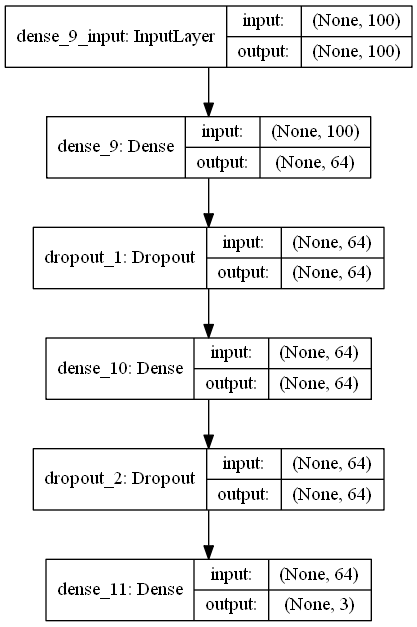

In [34]:
plot_model(
    drop_model,
    to_file = 'model_plot.png',
    show_shapes = True,
    show_layer_names = True
)

In [35]:
df.head(10)

,text,airline_sentiment
6072,Is chance get tickets Vegas stop? missed chan...,neutral
2082,I'm first time solo female traveller pretty s...,negative
1685,frustrating flying experience. One continuous...,negative
7364,WELL...my paid tickets NO assigned seats all....,negative
7462,waited hrs bags flight hrs,negative
4204,"no, flight Cancelled Flightlations (one due w...",negative
5876,"CEO Gary Kelly, ""You absolutely heroes!"" #Sou...",neutral
632,hard stay upset someone least TRY show remorse.,negative
4534,disappointed 'service' I've received. Checked...,negative
10976,will...sunday! Just days away,positive
